## State-feedback control

Consider the continuous-time system

$$
\dot{x}=Ax+Bu,
$$

where $u=Kx$, is the state-feedback control law.

The goal is to design the gain matrix $K$ by employing the Lyapunov theory. First, close the loop to write

$$
\dot{x}=Ax+BKx, \quad \mbox{or}, \quad \dot{x}=(A+BK)x.
$$

To provide a stability certificate for the closed-loop system, one must have:

* $V(x)>0 \rightarrow x^TPx>0$, or simply $P>0$.


* $\dot{V}(x)<0 \rightarrow \dot{x}^TPx+ {x}^TP\dot{x}<0$, or $x^T{(A+BK)}^TPx+x^TP(A+BK)x<0$, that can be written as

$$
(A+BK)^TP + P(A+BK)<0
$$

Note that it is not a linear condition. To circumvent this problem, we must first perform a congruence transformation by multiplying both sides of the inequality by $P^{-1}$

$$
P^{-1}(A+BK)^TPP^{-1} + P^{-1}P(A+BK)P^{-1}<0, \\
P^{-1}(A+BK)^T + (A+BK)P^{-1}<0
$$

Let us call $P^{-1}=Q$ to write

$$
Q(A+BK)^T + (A+BK)Q<0.
$$

Moreover, the following change of variables will be applied $KQ=Z$. In this sense one has

$$
QA^T+QK^TB^T + AQ+BKQ<0, \\
QA^T+Z^TB^T + AQ+BZ<0.
$$

Remember that one must have $P>0$ to guarantee that the Lyapunov function is positive definite. Then, the congruence transformation will be applied to write

$$P^{-1}PP^{-1}>0, \\
P^{-1}>0, \\
Q>0.
$$

At the end of the optimization procedure, we will be able to recover the gain matrix

$$
KQ=Z, \\
KQQ^{-1}=ZQ^{-1}, \\
K=ZQ^{-1}.
$$

### Example

Consider the following continuous-time system.

$$
\dot{x}=\begin{bmatrix} 1 & 1 \\ 0.5 & 1 \end{bmatrix}x + \begin{bmatrix} 1 \\ 1 \end{bmatrix}u
$$

The system is open-loop unstable. The goal is to design the sate-feedback control action $u=Kx$ such that the closed-loop system $A+BK$ is asymptotic stable.



In [1]:
import cvxpy as cp
import numpy as np

#System matrices
A = np.array([[1.0, 1.0],[0.5,1.0]])
B = np.array([[1.0],[1.0]])
eps=1e-3

#Dimensions
nx=A.shape[0]
nu=B.shape[1]

#Create the decision variable
Q = cp.Variable((nx,nx), PSD=True)
Z = cp.Variable((nu,nx))

#Add the constraints
constraints = [Q >> eps*np.eye(nx), Q@A.T+A@Q+Z.T@B.T+B@Z << -eps*np.eye(nx)]
#Create the objective function
objective = cp.Minimize(0)
#Define the problem to be solved
problem = cp.Problem(objective,constraints)
#Solve the problem
result = problem.solve()

#Print status and solution
if problem.status in ["optimal"]:
    Q = Q.value
    Z= Z.value

    print(f"status: {problem.status}")

    # Check if Q is positive definite
    eigenvalues = np.linalg.eigvals(Q)
    print(f"The eigenvalues of the Lyapunov matrix Q are: {eigenvalues}")

    # Check positive definiteness by verifying that all eigenvalues are positive
    if np.all(eigenvalues > 0):
        print("Q is positive definite.")
        Qinv=np.linalg.inv(Q)
        K=Z@Qinv
        print("The closed-loop system is asymptotic stable, and the gain matrix is K=",K)
        eigenvcl = np.linalg.eigvals(A+B@K)
        print(f"The eigenvalues of the closed-loop system are: {eigenvcl}")
    else:
        print("Q is not positive definite.")
else:
    print(f"Problem status: {problem.status}. No valid solution found.")

#Check the eigenvalues of the open loop system
eigenvA = np.linalg.eigvals(A)
print(f"The eigenvalues of the matrix A are: {eigenvA}")


status: optimal
The eigenvalues of the Lyapunov matrix Q are: [0.03988617 4.1084601 ]
Q is positive definite.
The closed-loop system is asymptotic stable, and the gain matrix is K= [[-8.58663468  2.28291986]]
The eigenvalues of the closed-loop system are: [-3.88073867 -0.42297616]
The eigenvalues of the matrix A are: [1.70710678 0.29289322]


In what follows we will plot the time-response of the closed-loop system, considering a random initial condition. The Lyapunov function $V=x'Px$ is also evaluated. Note that $P=Q^{-1}$.

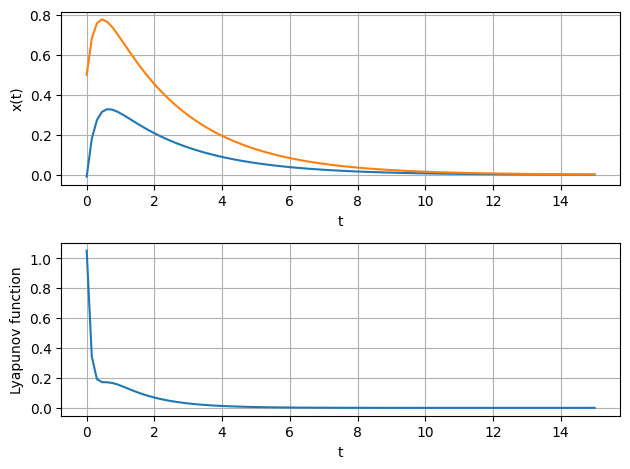

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#System matrices
A = np.array([[1.0, 1.0],[0.5,1.0]])
B = np.array([[1.0],[1.0]])
K= np.array([[-8.58663468, 2.28291986]])

#random initial condition
x0 = np.random.randn(2)

# Define the ODE
def system(x, t):
    dxdt = (A+B@K)@x
    return dxdt

# Simulation time
t0=0
tf=15
npt=100
t = np.linspace(t0,tf,npt)  # From t0 to tf with np points

# solve the ODE with the given initial condition
sol = odeint(system, x0, t)

# Taking the solution
x = sol[:,:]

x1 = sol[:, 0]  # First state
x2 = sol[:, 1]  # Second state

#Creating a vector to store the values of the Lyapunov function
V = np.zeros(len(t))

# Computing V=x'Px=x'Qinvx
for i in range(len(t)):
    x_i = np.array([x1[i], x2[i]])
    V[i] =  x_i.T@Qinv@x_i


plt.figure()
plt.subplot(211)
plt.plot(t, x)
plt.xlabel('t')
plt.ylabel('x(t)')
plt.grid(True)

plt.subplot(212)
plt.plot(t, V)
plt.xlabel('t')
plt.ylabel('Lyapunov function')
plt.grid(True)


plt.tight_layout()
plt.show()

